<a href="https://colab.research.google.com/github/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/blob/main/CODE_1005_1010_1012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


**Import necessary libraries**

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install bangla-stemmer

In [ ]:
import gdown
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time
from collections import Counter
import requests


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score, classification_report

from bangla_stemmer.stemmer import stemmer
from nltk.util import ngrams

**Load Dataset**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/DepressionDataset.csv")

**Drop Null Values**

In [ ]:
df.dropna(subset=['text', 'label'], inplace=True)

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'], df['label_encoded'], test_size=0.2, stratify=df['label_encoded'], random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


**TrainSet Description**

In [ ]:
display(X_train)

,text
9366,আমি কাজ শিখেছি টিভিতে । পরে লক্ষ্য করেছি এক সম...
6216,ডিপ্রেশনে মাঝে মাঝে চায় দুনিয়া থেকে বিদায় নিয়ে...
2127,অপেক্ষা করুন বন্ধু মোদি কিছুদিনের মধ্যে বাংলাদ...
5746,নিয়ম ভাঙ্গার মগজ জুড়ে এখন শুধুই তেপান্তরের ন...
7647,হাউস অব লর্ডসের সদস্য অ্যালেক্স কার্লাইল বলেছে...
...,...
1194,দেনমহর বেশিরভাগ নারীকে অসম্মান করাই জন্য দায়ীএ...
4650,বাংলাদেশ কারিগরি শিক্ষার ব্যবস্থা করা হোক
8138,দেশমাতা মুক্তির দাবিতে আজ সারাদেশে যুবদলের বিক...
2760,হৃদয়ে একটি অচেতন অনুভূতি অন্ধকারে ঢাকা বারবার...


In [ ]:
print("Label:")
print(df.label.unique())

Label:
['severe' 'moderate' 'mild' 'non_depressive' 'depressive']


In [ ]:
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

train_df = pd.DataFrame({'label': y_train})
val_df   = pd.DataFrame({'label': y_val})
test_df  = pd.DataFrame({'label': y_test})

train_counts = train_df['label'].value_counts()
val_counts   = val_df['label'].value_counts()
test_counts  = test_df['label'].value_counts()

all_classes = sorted(set(train_counts.index) | set(val_counts.index) | set(test_counts.index))

data = []
for cls in all_classes:
    train_n = train_counts.get(cls, 0)
    val_n   = val_counts.get(cls, 0)
    test_n  = test_counts.get(cls, 0)
    total   = train_n + val_n + test_n
    data.append([label_map[cls], total, train_n, val_n, test_n])
num_classes = len(label_encoder.classes_)

df_summary = pd.DataFrame(data, columns=["Class Name", "Total", "Train", "Validation", "Test"])
df_summary

,Class Name,Total,Train,Validation,Test
0,depressive,2083,1666,208,209
1,mild,1340,1072,134,134
2,moderate,670,536,67,67
3,non_depressive,5033,4026,504,503
4,severe,323,259,32,32


**EDA**

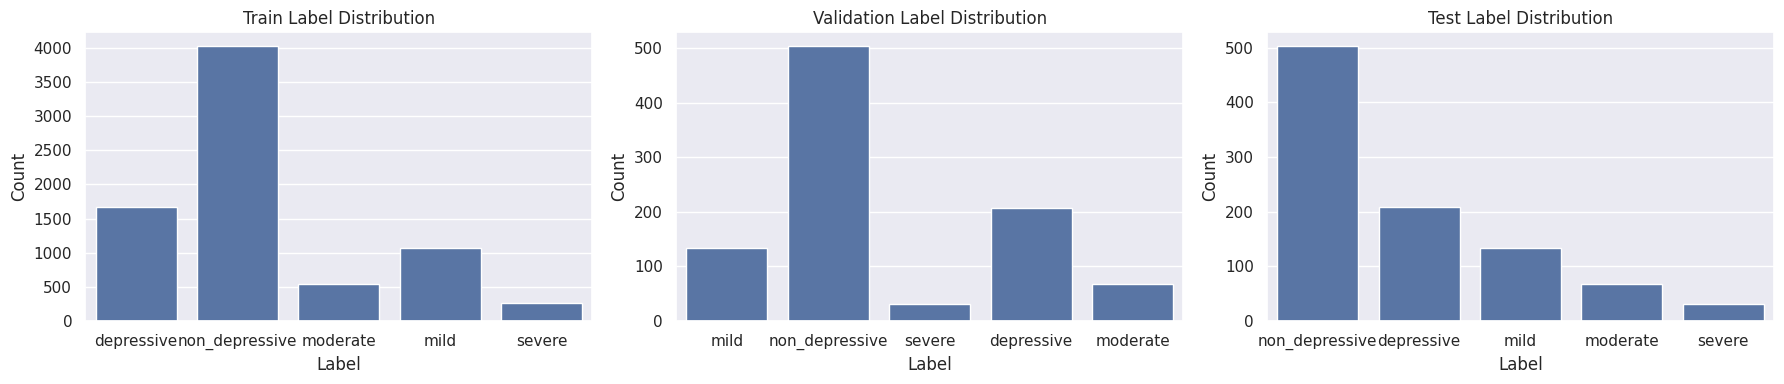

In [ ]:
sns.set(rc={'figure.figsize': (18, 4)})

train_df = pd.DataFrame({'label': [label_encoder.inverse_transform([y])[0] for y in y_train]})
val_df   = pd.DataFrame({'label': [label_encoder.inverse_transform([y])[0] for y in y_val]})
test_df  = pd.DataFrame({'label': [label_encoder.inverse_transform([y])[0] for y in y_test]})

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Train
sns.countplot(x='label', data=train_df, ax=axes[0])
axes[0].set_title('Train Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# Validation
sns.countplot(x='label', data=val_df, ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# Test
sns.countplot(x='label', data=test_df, ax=axes[2])
axes[2].set_title('Test Label Distribution')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


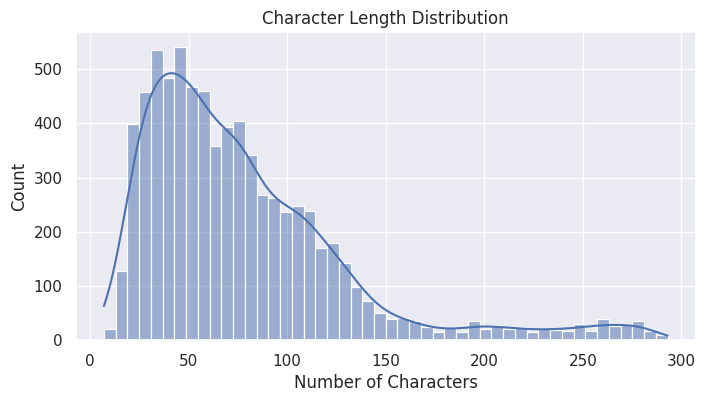

In [ ]:
train_df = pd.DataFrame({'text': X_train.tolist()})

train_df['char_len'] = train_df['text'].astype(str).apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(train_df['char_len'], kde=True)
plt.title("Character Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()



**Preprocessing/Cleaning**

In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
X_train = X_train.apply(lambda x: preprocessing(str(x)))
X_val   = X_val.apply(lambda x: preprocessing(str(x)))
X_test  = X_test.apply(lambda x: preprocessing(str(x)))

**Stopwords Removal**

In [ ]:
url = "https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/Bangla_stopwords.txt"
stopwords = requests.get(url).text.splitlines()

print(stopwords[:20])


['stop = [', "'অতএব','অন্তত','অন্য','অন্যত্র','অন্যথা','অন্যথায়','অন্যায়','অথচ','অথবা','অধীন','অধিক','অধিকাংশ','অনেক','অনেকটা','অন্যান্য','অনুরূপ',", "'অভ্যন্তরীণ','অবশ্য','অবশ্যই','অর্থাৎ','অর্থে','অলস','অসৎ','অসহায়','অহংকার','আজ','আজকাল','আগে','আগেই','আগামী','আছে','আছেন','আছে','আদি',", "'আপনি','আপনার','আপনাদের','আমরা','আমার','আমাদের','আমি','আবার','আবশ্যক','আর','আরও','আরেকটি','আরেকজন','আরেকবার','আরেকটা','আরেকজনকে',", "'আরেকভাবে','আসলে','ই','ইত্যাদি','ইন','উক্ত','উচিত','উদাহরণস্বরূপ','উদ্দেশ্য','উপর','উপরের','উভয়','উভয়ে','উত্তর','উনি','এক','একই',", "'একটু','একবার','একটি','একদিকে','একদম','এখন','এখনও','এখানে','এখানেই','এখনকার','এখনো','এটাই','এতে','এদের','এমন','এমনকি','এমনকি',", "'এর','এরপর','এরা','এরাই','এবং','এবার','এমনভাবে','এই','এসব','এটি','এইসব','ও','ওই','ওদের','ওইটি','ওখানে','ওর','ওরা','ওদেরকে',", "'কখন','কখনও','কখনো','কত','কতটা','কতজন','কতদিন','কতটা','কতদূর','কতক্ষণ','কতবার','কতগুলো','কম','কমপক্ষে','কমনীয়','কর','করছে','করছেন',", "'করতে','করলেন','করবে','করবেন','করলে','করানো','ক

In [ ]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]

    out=' '.join(stm)

    return str(out)

In [ ]:
X_train = X_train.apply(lambda x: stopwordRemoval(str(x)))
X_val   = X_val.apply(lambda x: stopwordRemoval(str(x)))
X_test  = X_test.apply(lambda x: stopwordRemoval(str(x)))

**Stemming**

In [ ]:
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [ ]:
X_train = X_train.apply(lambda x: stem_text(str(x)))
X_val   = X_val.apply(lambda x: stem_text(str(x)))
X_test  = X_test.apply(lambda x: stem_text(str(x)))

Streaming output truncated to the last 5000 lines.
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth r

In [ ]:
def generate_ngrams(text, n=2):
    tokens = text.split()
    return [' '.join(gram) for gram in ngrams(tokens, n)]

In [ ]:
X_train = X_train.apply(lambda x: ' '.join(generate_ngrams(x, n=2)))
X_val = X_val.apply(lambda x: ' '.join(generate_ngrams(x, n=2)))
X_test  = X_test.apply(lambda x: ' '.join(generate_ngrams(x, n=2)))

In [ ]:
MAX_VOCAB = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val   = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test  = pad_sequences(X_test_seq, maxlen=MAX_LEN)


**RNN**

In [ ]:
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

model_rnn = models.Sequential([
    layers.Embedding(vocab_size, 128, input_length=MAX_LEN),
    layers.SimpleRNN(64, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rnn.build(input_shape=(None, MAX_LEN))
model_rnn.summary()


checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model_rnn.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[es, checkpoint],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 128)       │     1,336,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,353,797 (5.16 MB)

 Trainable params: 1,353,797 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 1.22073, saving model to best_model_rnn.weights.h5
237/237 - 17s - 72ms/step - accuracy: 0.4954 - loss: 1.3294 - val_accuracy: 0.5333 - val_loss: 1.2207
Epoch 2/40

Epoch 2: val_loss improved from 1.22073 to 1.13832, saving model to best_model_rnn.weights.h5
237/237 - 9s - 39ms/step - accuracy: 0.5405 - loss: 1.2283 - val_accuracy: 0.5725 - val_loss: 1.1383
Epoch 3/40

Epoch 3: val_loss improved from 1.13832 to 1.07665, saving model to best_model_rnn.weights.h5
237/237 - 10s - 44ms/step - accuracy: 0.5747 - loss: 1.1152 - val_accuracy: 0.5735 - val_loss: 1.0767
Epoch 4/40

Epoch 4: val_loss improved from 1.07665 to 1.03115, saving model to best_model_rnn.weights.h5
237/237 - 10s - 43ms/step - accuracy: 0.6183 - loss: 0.9992 - val_accuracy: 0.6032 - val_loss: 1.0312
Epoch 5/40

Epoch 5: val_loss did not improve from 1.03115
237/237 - 9s - 37ms/step - accuracy: 0.6322 - loss: 0.9320 - val_accuracy: 0.5831 - val_loss: 1.0320
Epoch 6/40

E

In [ ]:
url = "https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/best_model_rnn.weights.h5"
gdown.download(url, "best_model_rnn.weights.h5", quiet=False)
model_rnn.load_weights("best_model_rnn.weights.h5")

Downloading...
From: https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/best_model_rnn.weights.h5
To: /content/best_model_rnn.weights.h5
100%|██████████| 16.3M/16.3M [00:00<00:00, 140MB/s]


In [ ]:
loss, acc = model_rnn.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5991 - loss: 1.0763
Test accuracy: 0.5979


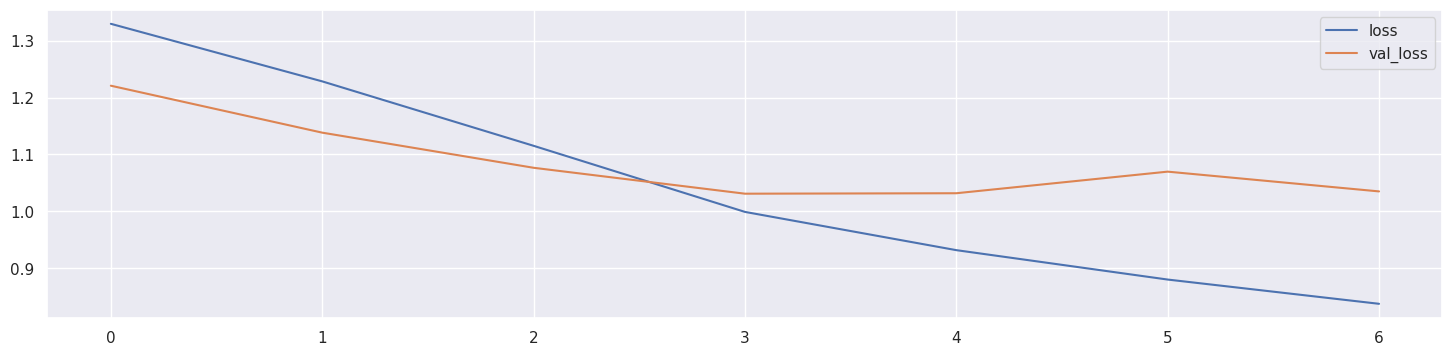

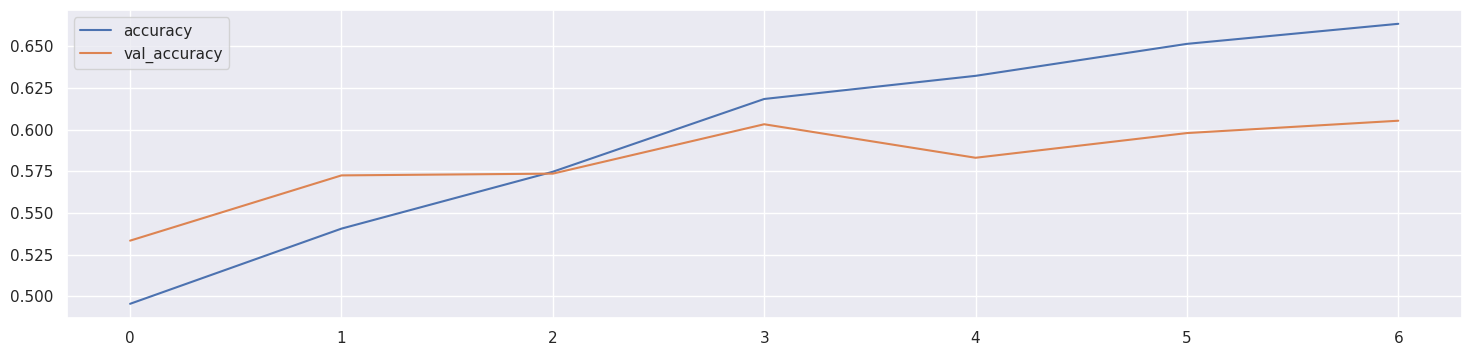

In [ ]:
history_frame = pd.DataFrame(history_rnn.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
y_pred = model_rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precision: 0.4559705131350372
Recall: 0.5978835978835979
F1 Score: 0.5170892768615728


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.40      0.57      0.47       209
           1       0.00      0.00      0.00       134
           2       0.00      0.00      0.00        67
           3       0.69      0.88      0.78       503
           4       0.00      0.00      0.00        32

    accuracy                           0.60       945
   macro avg       0.22      0.29      0.25       945
weighted avg       0.46      0.60      0.52       945



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


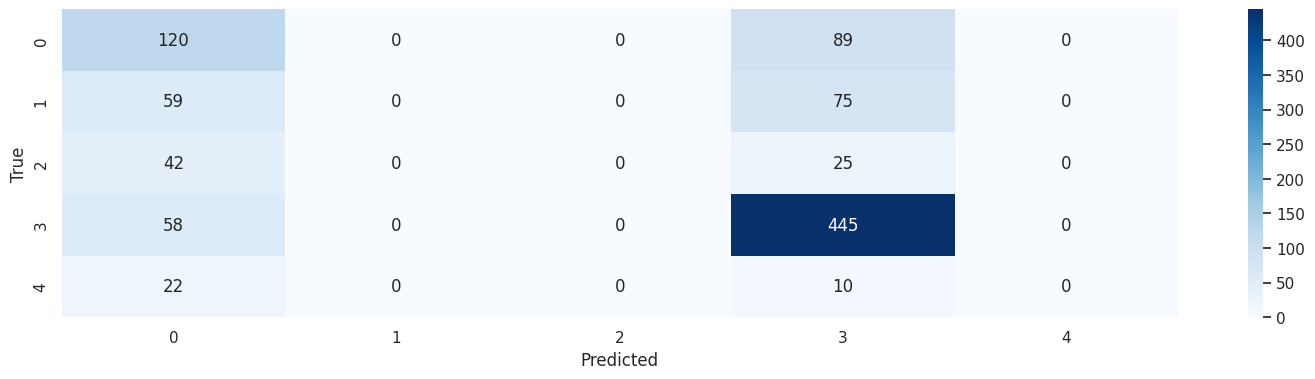

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Example Bangla sentence
custom_sentence = "আজকের আবহাওয়া খুব সুন্দর।"

In [ ]:
processed_sentence = preprocessing(custom_sentence)
processed_sentence = stopwordRemoval(processed_sentence)
processed_sentence = stem_text(processed_sentence)
processed_sentence = generate_ngrams(processed_sentence, n = 2)


# Convert text to sequence
seq = tokenizer.texts_to_sequences([processed_sentence])

# Pad it to same length as training data
padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

applied first rules..
applied fourth rules..
applied first rules..


In [ ]:
# Get prediction
pred = model_rnn.predict(padded_seq)

# For classification
pred_label = np.argmax(pred, axis=1)[0]

print("🔹 Predicted Label:", pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🔹 Predicted Label: 3


In [ ]:
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("🔹 Predicted Class:", label_map[pred_label])

🔹 Predicted Class: non_depressive


**LSTM**

In [ ]:

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

model_lstm = models.Sequential([
    layers.Embedding(vocab_size, 128, input_length=MAX_LEN),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.build(input_shape=(None, MAX_LEN))
model_lstm.summary()


checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model_lstm.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[es, checkpoint],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 128)       │     1,336,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,390,853 (5.31 MB)

 Trainable params: 1,390,853 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.95330, saving model to best_model_lstm.weights.h5
237/237 - 38s - 159ms/step - accuracy: 0.5646 - loss: 1.1425 - val_accuracy: 0.6307 - val_loss: 0.9533
Epoch 2/40

Epoch 2: val_loss improved from 0.95330 to 0.89203, saving model to best_model_lstm.weights.h5
237/237 - 40s - 168ms/step - accuracy: 0.6517 - loss: 0.8571 - val_accuracy: 0.6254 - val_loss: 0.8920
Epoch 3/40

Epoch 3: val_loss did not improve from 0.89203
237/237 - 53s - 224ms/step - accuracy: 0.6996 - loss: 0.7100 - val_accuracy: 0.6265 - val_loss: 0.9377
Epoch 4/40

Epoch 4: val_loss did not improve from 0.89203
237/237 - 31s - 131ms/step - accuracy: 0.7502 - loss: 0.6190 - val_accuracy: 0.6053 - val_loss: 0.9624
Epoch 5/40

Epoch 5: val_loss did not improve from 0.89203
237/237 - 31s - 130ms/step - accuracy: 0.7800 - loss: 0.5355 - val_accuracy: 0.5947 - val_loss: 1.0692


In [ ]:
url = "https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/best_model_lstm.weights.h5"
gdown.download(url, "best_model_lstm.weights.h5", quiet=False)
model_lstm.load_weights("best_model_lstm.weights.h5")

Downloading...
From: https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/best_model_lstm.weights.h5
To: /content/best_model_lstm.weights.h5
100%|██████████| 16.7M/16.7M [00:00<00:00, 142MB/s]


In [ ]:
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6239 - loss: 0.9698
Test accuracy: 0.6296


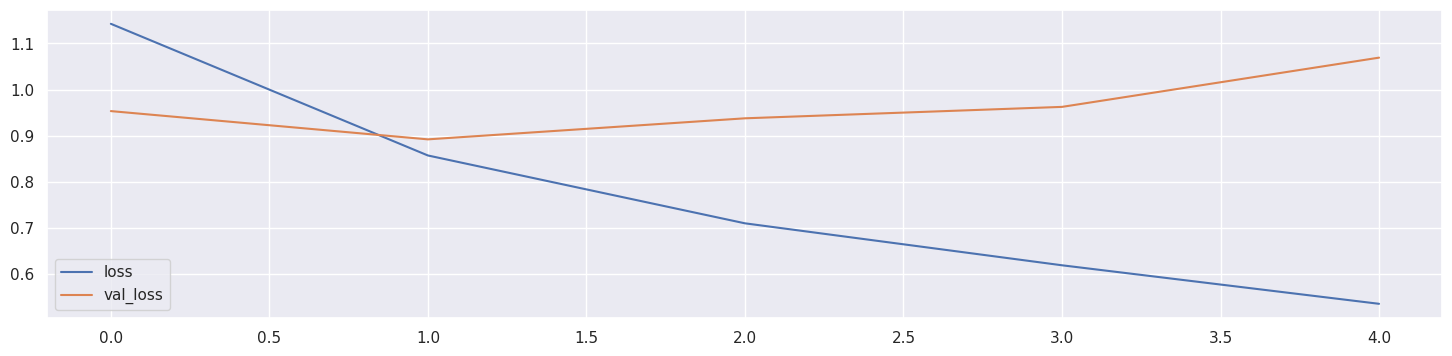

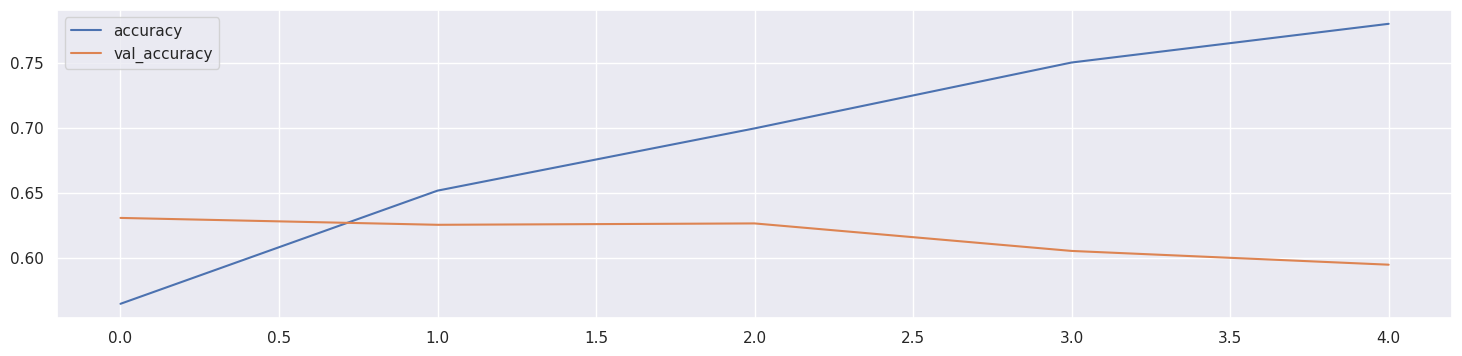

In [ ]:
history_frame = pd.DataFrame(history_lstm.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Precision: 0.5438503552200987
Recall: 0.6296296296296297
F1 Score: 0.5595686925098794


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.41      0.72      0.52       209
           1       0.00      0.00      0.00       134
           2       0.33      0.03      0.05        67
           3       0.78      0.88      0.82       503
           4       0.50      0.03      0.06        32

    accuracy                           0.63       945
   macro avg       0.40      0.33      0.29       945
weighted avg       0.54      0.63      0.56       945



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


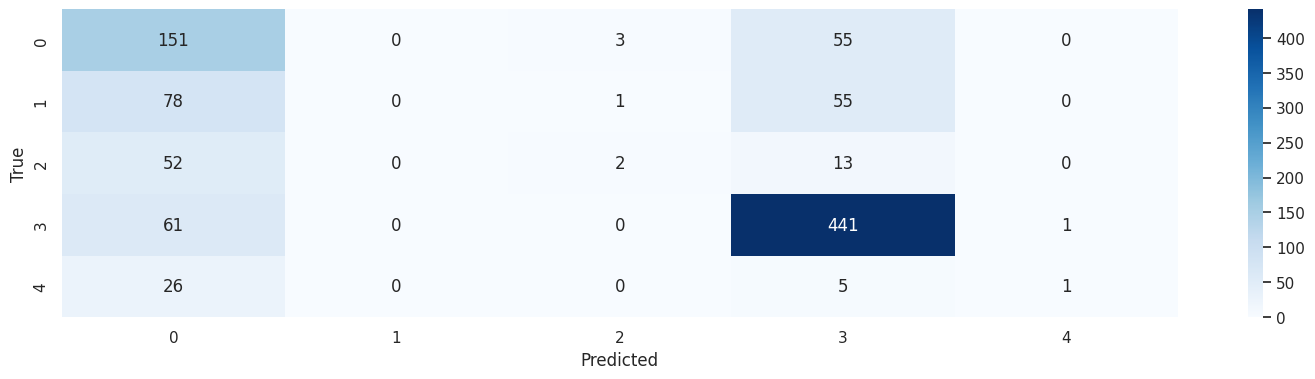

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Example Bangla sentence
custom_sentence = "আজকের আবহাওয়া খুব সুন্দর।"

In [ ]:
processed_sentence = preprocessing(custom_sentence)
processed_sentence = stopwordRemoval(processed_sentence)
processed_sentence = stem_text(processed_sentence)
processed_sentence = generate_ngrams(processed_sentence, n = 2)


# Convert text to sequence
seq = tokenizer.texts_to_sequences([processed_sentence])

# Pad it to same length as training data
padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')


applied first rules..
applied fourth rules..
applied first rules..


In [ ]:
# Get prediction
pred = model_lstm.predict(padded_seq)

# For classification
pred_label = np.argmax(pred, axis=1)[0]

print("🔹 Predicted Label:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
🔹 Predicted Label: 3


In [ ]:
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("🔹 Predicted Class:", label_map[pred_label])

🔹 Predicted Class: non_depressive


**Bi-Directional LSTM**

In [ ]:
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

model_bilstm = models.Sequential([
    layers.Embedding(vocab_size, 128, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bilstm.build(input_shape=(None, MAX_LEN))
model_bilstm.summary()


checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model_bilstm.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[es, checkpoint],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 128)       │     1,336,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,357 (5.51 MB)

 Trainable params: 1,444,357 (5.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.95073, saving model to best_model_bilstm.weights.h5
237/237 - 67s - 282ms/step - accuracy: 0.5745 - loss: 1.1399 - val_accuracy: 0.6360 - val_loss: 0.9507
Epoch 2/40

Epoch 2: val_loss improved from 0.95073 to 0.90336, saving model to best_model_bilstm.weights.h5
237/237 - 58s - 244ms/step - accuracy: 0.6552 - loss: 0.8677 - val_accuracy: 0.6413 - val_loss: 0.9034
Epoch 3/40

Epoch 3: val_loss improved from 0.90336 to 0.89557, saving model to best_model_bilstm.weights.h5
237/237 - 59s - 248ms/step - accuracy: 0.6935 - loss: 0.7250 - val_accuracy: 0.6349 - val_loss: 0.8956
Epoch 4/40

Epoch 4: val_loss did not improve from 0.89557
237/237 - 57s - 242ms/step - accuracy: 0.7285 - loss: 0.6294 - val_accuracy: 0.6138 - val_loss: 1.0232
Epoch 5/40

Epoch 5: val_loss did not improve from 0.89557
237/237 - 57s - 242ms/step - accuracy: 0.7669 - loss: 0.5567 - val_accuracy: 0.6169 - val_loss: 1.1151
Epoch 6/40

Epoch 6: val_loss did not improv

In [ ]:
url = "https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/best_model_bilstm.weights.h5"
gdown.download(url, "best_model_bilstm.weights.h5", quiet=False)
model_bilstm.load_weights("best_model_bilstm.weights.h5")

Downloading...
From: https://raw.githubusercontent.com/Showrup1005/RNN-Based-Depression-Detection-in-Bangla-using-TensorFlow-and-Keras/main/best_model_bilstm.weights.h5
To: /content/best_model_bilstm.weights.h5
100%|██████████| 17.4M/17.4M [00:00<00:00, 144MB/s]


In [ ]:
loss, acc = model_bilstm.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5869 - loss: 0.9916
Test accuracy: 0.6021


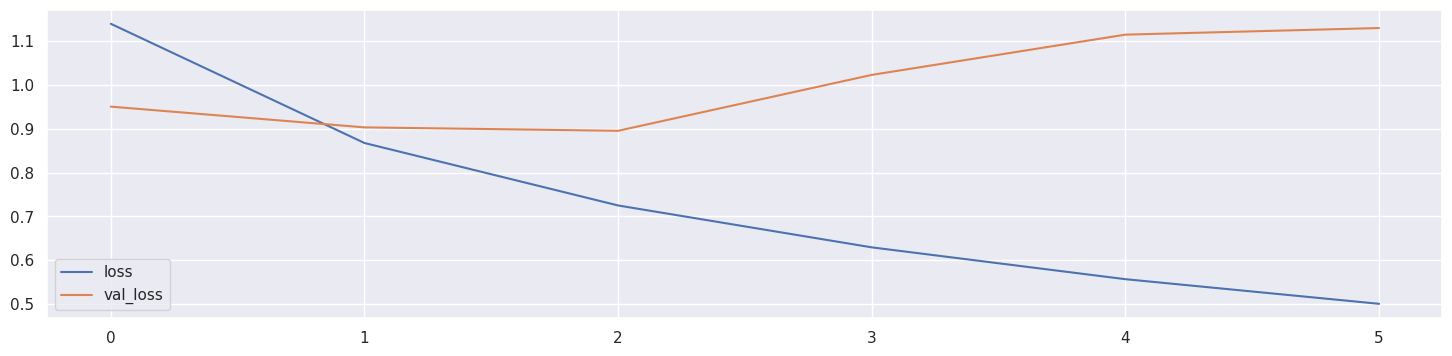

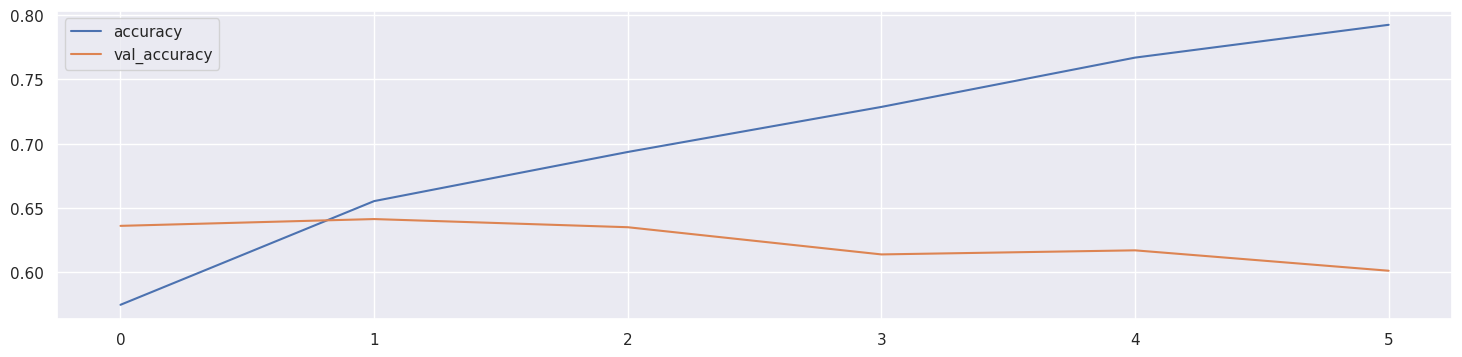

In [ ]:
history_frame = pd.DataFrame(history_bilstm.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
y_pred = model_bilstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Precision: 0.5827562823931312
Recall: 0.6021164021164022
F1 Score: 0.5895122414294909


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.40      0.31      0.35       209
           1       0.29      0.30      0.30       134
           2       0.27      0.22      0.25        67
           3       0.79      0.85      0.82       503
           4       0.44      0.66      0.53        32

    accuracy                           0.60       945
   macro avg       0.44      0.47      0.45       945
weighted avg       0.58      0.60      0.59       945



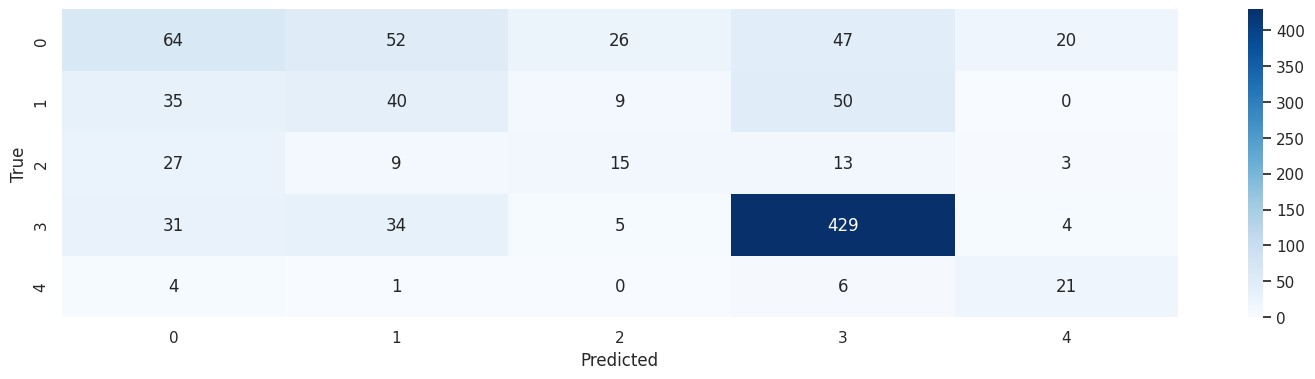

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Example Bangla sentence
custom_sentence = "আজকের আবহাওয়া খুব সুন্দর।"

In [ ]:
processed_sentence = preprocessing(custom_sentence)
processed_sentence = stopwordRemoval(processed_sentence)
processed_sentence = stem_text(processed_sentence)
processed_sentence = generate_ngrams(processed_sentence, n = 2)


# Convert text to sequence
seq = tokenizer.texts_to_sequences([processed_sentence])

# Pad it to same length as training data
padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

applied first rules..
applied fourth rules..
applied first rules..


In [ ]:
# Get prediction
pred = model_bilstm.predict(padded_seq)

# For classification
pred_label = np.argmax(pred, axis=1)[0]

print("🔹 Predicted Label:", pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🔹 Predicted Label: 3


In [ ]:
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("🔹 Predicted Class:", label_map[pred_label])

🔹 Predicted Class: non_depressive
